<img src="AW&H2015.png" style="float: left">

<img src="flopylogo.png" style="float: center">

# History match the Freyberg model using a single ``K`` parameter

Freyberg (1988) was notable for the discussing what is often called "point calibration" and "overfitting". It is a heterogenous 2D areal (1-layer) model that is a step up in complexity from our xsec model. Recall it looks like this, as shown in the original Freyberg (1988) paper on the left, and a Groundwater Vistas version on the right (from the file in the GW_Vistas subdirectory).   

<img src="Freburg1988_fig1.png" style="float: left">
<img src="Freyberg_k_plot_GW_Vistas.png" style="float: right">

As we discussed in our first notebook, one way to get to an optimal model is to start simple and add complexity. To do this righte we need to add our forecasts first along with the calibration targets, and look at both as more model complexity is added.  One of the findings of the Freyberg (1988) model is that some students made their model too complex, which diminished its performance for the prediction of interest. Starting simple will keep us out of danger (at least for this notebook). 

This version of the Freyberg model has 3 stress periods:  1 steady state -> 1 transient for 5 years -> 1 steady state

The river stage and node conductance changes in each stress period (see .riv file)

The recharge starts out wetter in stress period one, then is drier in stress periods 2 and 3 (see .rch file)

Pumping well discharge changes each stress period (see .wel file)

In addition to heads and fluxes, MODPATH is also included in the PEST++ model run file to perform particle tracking after MODFLOW finishes

***********************************************
__So, the objectives of this notebook are to:__

1) Ease you into the Freyberg model as we'll be using it for the rest of the class

2) Revisit the PEST control (pst) file

3) Look at typical summary statistics and plots the describe our degree of fit

4) Look at how head data constraints ripple to different forecast types

## Standard two blocks to prep the notebook

In [1]:
%matplotlib inline
import os
import sys
sys.path.append("..")
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import pyemu

In [2]:
import freyberg_setup as fs
pst_name = fs.PST_NAME_UN
working_dir = fs.WORKING_DIR_UN
fs.setup_pest_un()
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 0
pst.write(os.path.join(working_dir,pst_name))

['.DS_Store', 'botm.ref', 'extract_zone_array.py', 'forecasts_true.csv', 'freyberg.bas', 'freyberg.dbf', 'freyberg.dis', 'freyberg.hds', 'freyberg.heads', 'freyberg.heads_potobs.ins', 'freyberg.hyd', 'freyberg.list', 'freyberg.locations', 'freyberg.mpbas', 'freyberg.mpenpt', 'freyberg.mplist', 'freyberg.mpnam', 'freyberg.mppthln', 'freyberg.mpsim', 'freyberg.oc', 'freyberg.pcg', 'freyberg.rivflux', 'freyberg.shp', 'freyberg.shx', 'freyberg.travel', 'freyberg.truth.lpf', 'freyberg.truth.nam', 'freyberg.truth.rch', 'freyberg.truth.riv', 'freyberg.truth.wel', 'hk.truth.ref', 'hk.zones', 'ibound.ref', 'kzone.ref', 'mpath.in', 'potobs_group.csv', 'Process_output.py', 'really_noisy_heads.txt', 'run_true_model.py', 'strt.ref', 'Weights_and_best_PHI.xlsx']

changing model workspace...
   freyberg_un
FloPy is using the following executable to run the model: /Users/jwhite/Dev/GW1876/activities/freyberg_k/freyberg_un/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL S

## We've given you all the files you need to run this PEST++ on this model.  Open up the .pst file.  To guide your eyes through the PEST control file, answer these questions:

1) How many parameters are we running? 

2) How many are adjustable? 

3) How many types of observations are included?

4) How many forecasts? What types?

5) How many template (tpl) files do we have?

6) How many instruction (ins) files do we have? 

## Now that you know the .ins, and .tpl files, open them in a text editor (make sure you are looking at the ones in /activities/freyberg_k subdirectory). In a seperate terminal window, run TEMPCHEK, INSCHEK and PESTCHEK on the files we've given you. 

### Okay, you've got running PEST utilities in a seperate terminal window by now?  To speed things up we've given you a way to execute these utilities from within the Freyberg notebook.  We've included the equivalent version of what you just did in the next four code blocks.  Execute the code block then look at terminal window where you launched this notebook.

In [3]:
pyemu.helpers.run("tempchek freyberg.rch.tpl",cwd=working_dir)

run():tempchek freyberg.rch.tpl


In [4]:
pyemu.helpers.run("tempchek hk.ref.tpl",cwd=working_dir)

run():tempchek hk.ref.tpl


In [5]:
pyemu.helpers.run("inschek freyberg.heads.ins freyberg.heads",cwd=working_dir)

run():inschek freyberg.heads.ins freyberg.heads


In [6]:
pyemu.helpers.run("pestchek {0}".format(pst_name),cwd=working_dir)

run():pestchek freyberg_un.pst


# Okay, let's run this thing. 

## Because we call a program from within the Jupyter Notebook you have to look at the terminal window that you used to start the notebook to see the screen report of the run.  So, when executing this next block look at your terminal window to see the run.  It will say "Simulation complete..." when finished.

### NOTE:  And/or wait until the standard out  reports a "0" below this next block (=when the run is finished) before going on.

In [7]:
pyemu.helpers.run("pestpp {0} ".format(pst_name),cwd=working_dir)

run():pestpp freyberg_un.pst 


## ``PEST++`` only ran the model one time - why?

Yeah, that's right, the NOPTMAX=0 thing again.  We had that set to zero because we want to check the plumbing before burning the silicon. Did everything run (i.e., did you see "Simulation Complete..." in your terminal window?  Like before, you *could* change NOPTMAX to 20 in a text editor.  But, pyemu can do it for you with the next block.  

In [8]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.control_data.noptmax = 20
pst.write(os.path.join(working_dir,pst_name))

#### "Trust but verify"....by running PESTCHEK

In [9]:
pyemu.helpers.run("pestchek {0} ".format(pst_name),cwd=working_dir)

run():pestchek freyberg_un.pst 


### Now we let's run it.  Just like before  you have to look at the terminal window that you used to start the notebook to see the screen report of the run.  So, when executing this next block look at your terminal window to see the run.  It will say "Simulation complete..." when finished.

Or wait until the standard out  reports a "0" below this next block (=when the run is finished) before going on.

In [10]:
pyemu.helpers.run("pestpp {0} ".format(pst_name),cwd=working_dir)

run():pestpp freyberg_un.pst 


### Let's explore the results

First let's look at the measurement objective function (Phi), which is calculated using the sum of squared weighted residuals.   

In [11]:
df_obj = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".iobj")),index_col=0)
df_obj

,model_runs_completed,total_phi,measurement_phi,regularization_phi,flx_river_l,head,vol_recharg,vol_storage,vol_in-out,foretrav,...,flx_wells,flx_storage,vol_percent,flx_in-out,vol_total,vol_constan,calflux,flx_recharg,vol_wells,flx_percent
iteration,,,,,,,,,,,,,,,,,,,,,
0,0,1207.910,1207.910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,743.190,743.190,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,15,738.895,738.895,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,23,738.882,738.882,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x102a9ccf8>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1112ed4e0>], dtype=object)

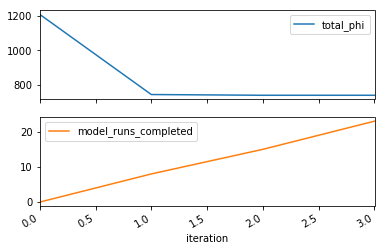

In [12]:
df_obj.loc[:,["total_phi","model_runs_completed"]].plot(subplots=True)

### Which are the only target group to matter?  How was that accomplished in the PEST control file?

For this problem, recall our objective function is calculated using this equation:


<img src="SOSWR_eq_AW&H2015.png" style="float: center">

where Phi is the "sum of squared weighted residuals" that we look to minimize, *whi* is the weight for the ith head observation; *hm* is the measured (observed) head target; *hs* is the simulated head; and n is the number of observations.

# Hey, we told PEST to try 20 parameter estimation upgrades but it stopped at 3!  What gives?!?

(hint: search the .rec file for OPTIMIZATION COMPLETE)

PEST and PEST++ will quit the parameter estimation process if one of these 4 conditions is met:

1) The maximum number of interations specified in NOPTMAX is reached

2) The fit is not getting any better based on a user-supplied closure

3) The parameters are not changing based on a user-supplied closure

4) The user killed the run, usually with a ctrl-c  (happens quite frequently)

##  Let's evaulate our fit using the observed-simulated residuals

### Let's plot up the 1:1 line of measured to simulated values (should be in most all evaluations). The closer the line the better the fit.

In [13]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
pst.res

,name,group,measured,modelled,residual,weight
name,,,,,,
flx_constan_19700102,flx_constan_19700102,flx_constan,-4.073839e+02,-2.545164e+02,-152.867497,0.0
flx_in-out_19700102,flx_in-out_19700102,flx_in-out,-1.373190e+01,-4.553200e+00,-9.178700,0.0
flx_percent_19700102,flx_percent_19700102,flx_percent,-2.200000e-01,-7.000000e-02,-0.150000,0.0
flx_recharg_19700102,flx_recharg_19700102,flx_recharg,6.004800e+03,6.081250e+03,-76.450000,0.0
flx_river_l_19700102,flx_river_l_19700102,calflux,-3.706027e+03,-3.831287e+03,125.259621,0.0
flx_storage_19700102,flx_storage_19700102,flx_storage,0.000000e+00,0.000000e+00,0.000000,0.0
flx_total_19700102,flx_total_19700102,flx_total,-1.373193e+01,-4.553223e+00,-9.178707,0.0
flx_wells_19700102,flx_wells_19700102,flx_wells,-1.905120e+03,-2.000000e+03,94.880000,0.0
flx_constan_19750101,flx_constan_19750101,flx_constan,-1.796678e+02,-4.476510e+01,-134.902698,0.0


,name,group,measured,modelled,residual,weight
name,,,,,,
cr03c16_19700102,cr03c16_19700102,calhead,18.864677,19.827669,-0.962992,5.0
cr03c10_19700102,cr03c10_19700102,calhead,20.920237,22.514858,-1.594621,5.0
cr04c9_19700102,cr04c9_19700102,calhead,23.287189,23.052885,0.234304,5.0
cr10c2_19700102,cr10c2_19700102,calhead,28.141190,29.502222,-1.361032,5.0
cr14c11_19700102,cr14c11_19700102,calhead,20.524639,18.198273,2.326366,5.0
cr16c17_19700102,cr16c17_19700102,calhead,15.522017,17.452532,-1.930515,5.0
cr22c11_19700102,cr22c11_19700102,calhead,19.704904,17.142292,2.562612,5.0
cr23c16_19700102,cr23c16_19700102,calhead,15.644862,15.725641,-0.080779,5.0
cr25c5_19700102,cr25c5_19700102,calhead,21.413268,21.405073,0.008194,5.0


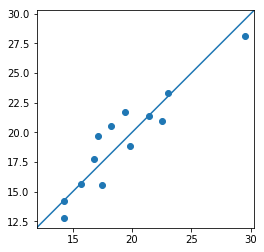

In [14]:
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
res_nz = pst.res.loc[pst.nnz_obs_names,:]
ax = plt.subplot(111,aspect="equal")
ax.scatter(res_nz.modelled,res_nz.measured)
xlim,ylim = ax.get_xlim(),ax.get_ylim()
mx,mn = max(xlim[1],ylim[1]),min(xlim[0],ylim[0])

ax.plot([mn,mx],[mn,mx])
ax.set_xlim(mn,mx)
ax.set_ylim(mn,mx)
#ax.grid()
res_nz

### Not a bad fit!  Thanks PEST++.

### We can also look at the residual (y-axis) compared to the observation magnitude (x-axis).  The closer the circle is to the black line the better the fit.  The mean residual is shown as a red line, the pink zone is 1 standard deviation on either side of the mean.

# Now let's look at what the calibration did for uncertainty

### First, let's look the change in uncertainty for our one horizontal hydraulic conductivity (Kh) parameter

In [24]:
df_paru = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".par.usum.csv")),index_col=0)
df_paru

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
HK,0.69897,0.5,-0.30103,1.69897,0.840943,0.054463,0.732017,0.949868


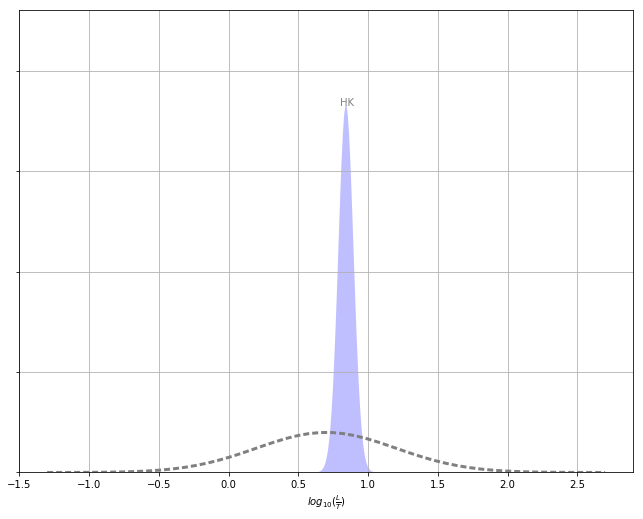

In [28]:
ax = pyemu.helpers.plot_summary_distributions(df_paru,label_post=True)
ax.set_xlabel("$log_{10}(\\frac{L}{T})$")

### NOTE: Because we log transformed the Kh parameter the uncertainty results are reported as logrithms in the dataframe above.  What you'll see in the MODFLOW input file is the non-log transformed Kh value, which is 10^0.693406 = 4.9465457


# Now let's look at changes in model forecast uncertainty

In [29]:
df_predu = pd.read_csv(os.path.join(working_dir,pst_name.replace(".pst",".pred.usum.csv")),index_col=0)
df_predu

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
FLX_RIVER_L_19750102,-1436.1400,212.304000,-1860.7500,-1011.5400,-1487.5700,23.125300,-1533.8200,-1441.3200
FR01C13_19750102,20.5560,0.763994,19.0280,22.0840,20.3039,0.083218,20.1375,20.4704
FR02C02_19750102,27.1473,5.813150,15.5210,38.7736,25.3133,0.633201,24.0469,26.5797
FR03C10_19750102,22.0427,2.440350,17.1620,26.9234,21.2456,0.265816,20.7140,21.7772
FR03C16_19750102,19.6050,0.310456,18.9841,20.2259,19.5016,0.033817,19.4340,19.5692
FR04C9_19750102,22.4907,2.894170,16.7024,28.2791,21.5493,0.315249,20.9188,22.1798
FR09C15_19750102,17.0955,1.042820,15.0099,19.1812,17.4461,0.113589,17.2189,17.6733
FR10C2_19750102,28.4562,7.083020,14.2902,42.6223,26.2424,0.771522,24.6994,27.7854
FR14C11_19750102,17.7482,0.656200,16.4358,19.0606,17.5293,0.071477,17.3863,17.6723


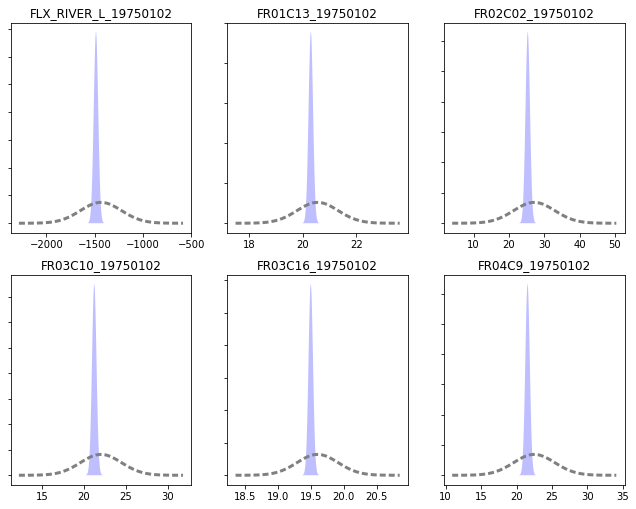

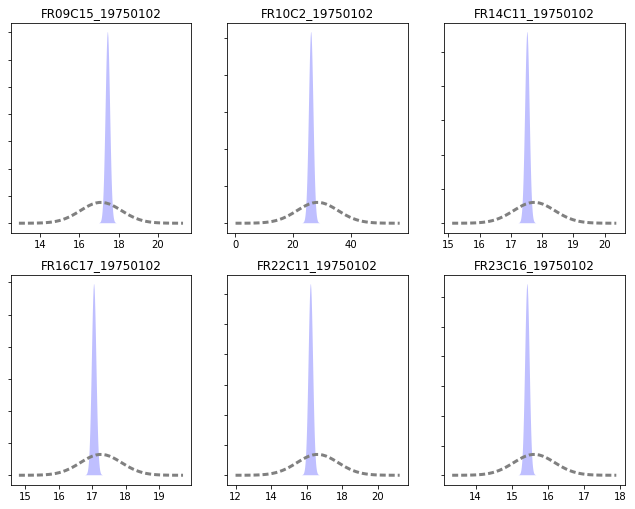

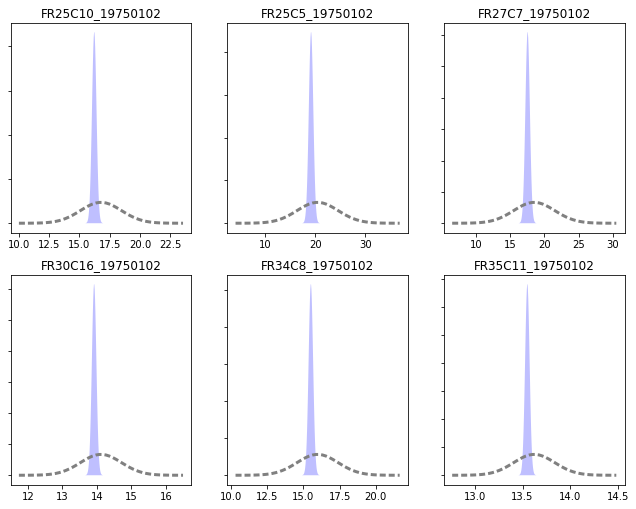

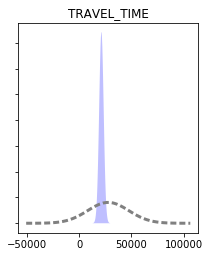

In [30]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu,subplots=True)


### Or comparing prior to posterior variance


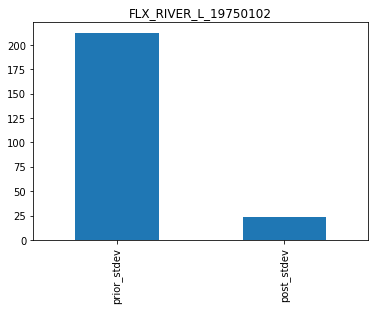

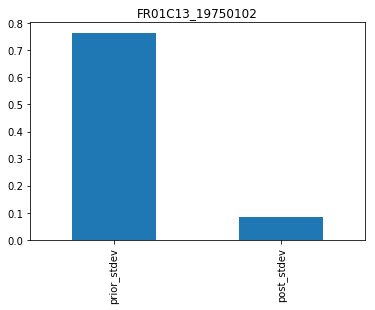

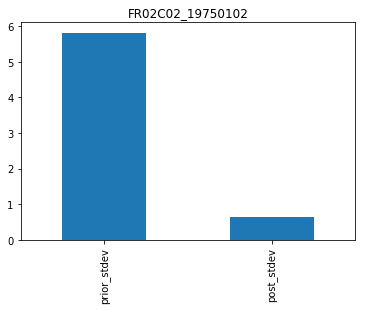

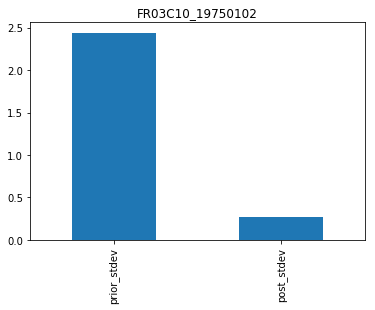

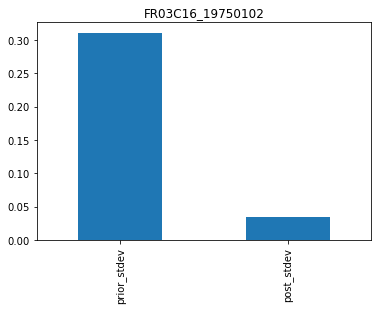

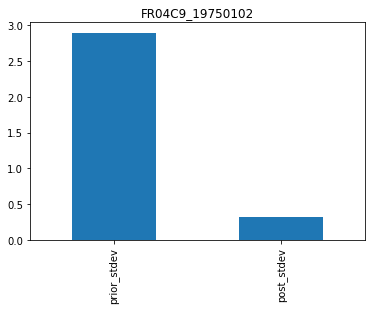

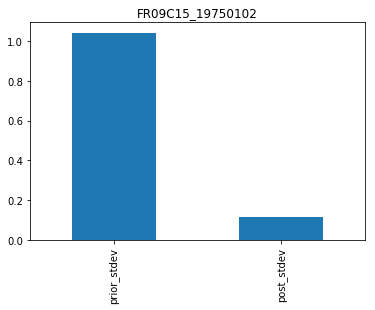

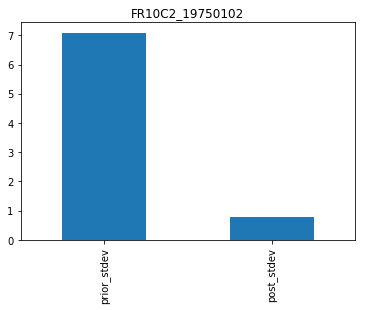

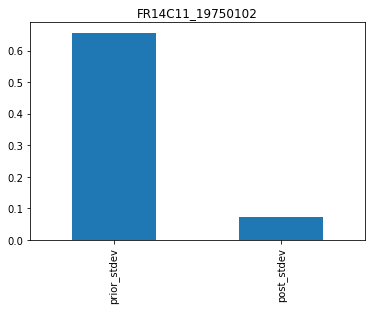

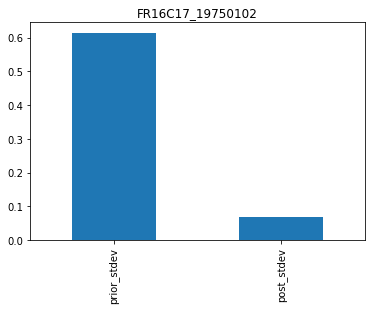

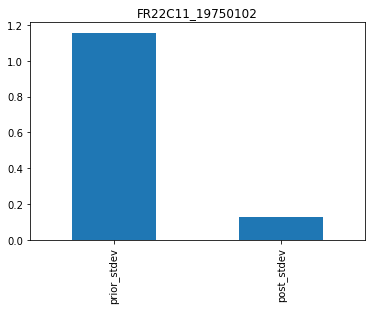

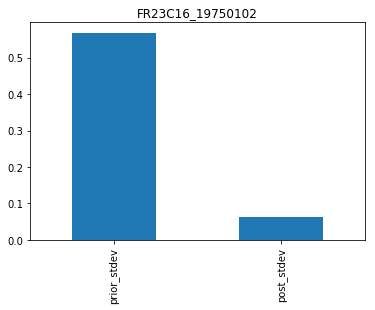

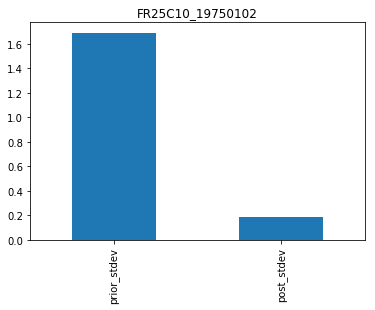

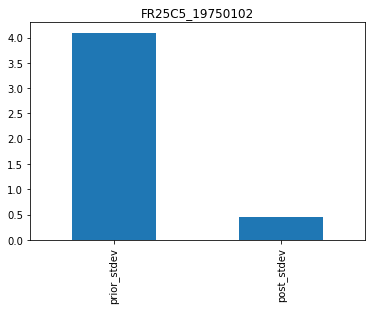

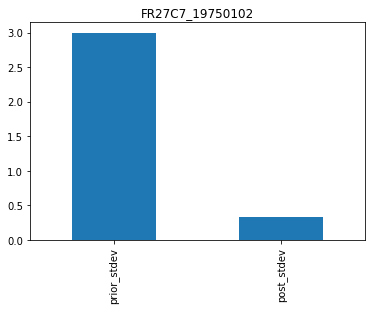

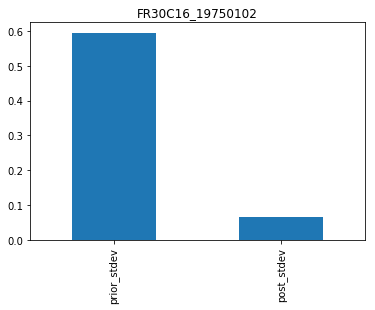

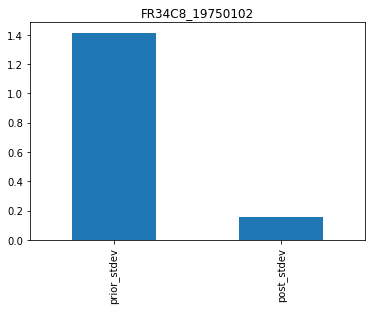

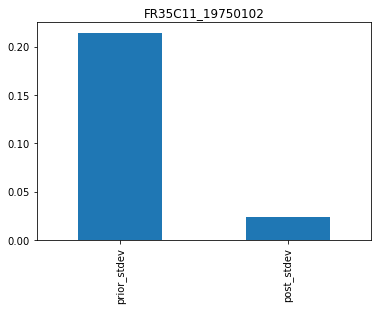

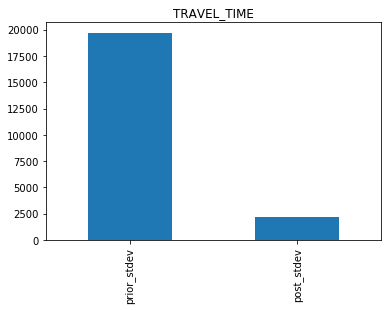

In [31]:
for forecast in df_predu.index:
    ax = df_predu.loc[forecast,["prior_stdev","post_stdev"]].plot(kind="bar")
    ax.set_title(forecast)
    plt.show()

### And we can use summary statistics to help be quantitative on the reduction in forecast uncertainty

In [32]:
df_predu.loc[:,"percent_reduction"] = 100.0 * (1.0 - (df_predu.post_stdev / df_predu.prior_stdev))
df_predu.percent_reduction

name
FLX_RIVER_L_19750102    89.107459
FR01C13_19750102        89.107454
FR02C02_19750102        89.107437
FR03C10_19750102        89.107464
FR03C16_19750102        89.107442
FR04C9_19750102         89.107447
FR09C15_19750102        89.107516
FR10C2_19750102         89.107443
FR14C11_19750102        89.107452
FR16C17_19750102        89.107455
FR22C11_19750102        89.107484
FR23C16_19750102        89.107453
FR25C10_19750102        89.107439
FR25C5_19750102         89.107452
FR27C7_19750102         89.107456
FR30C16_19750102        89.107454
FR34C8_19750102         89.107418
FR35C11_19750102        89.107440
TRAVEL_TIME             89.107439
Name: percent_reduction, dtype: float64

### Does it make sense that the travel time uncertainty would be reduced in the same proportion as the head forecasts?

Just for fun, let's look again at forecast uncertainty with the "truth"

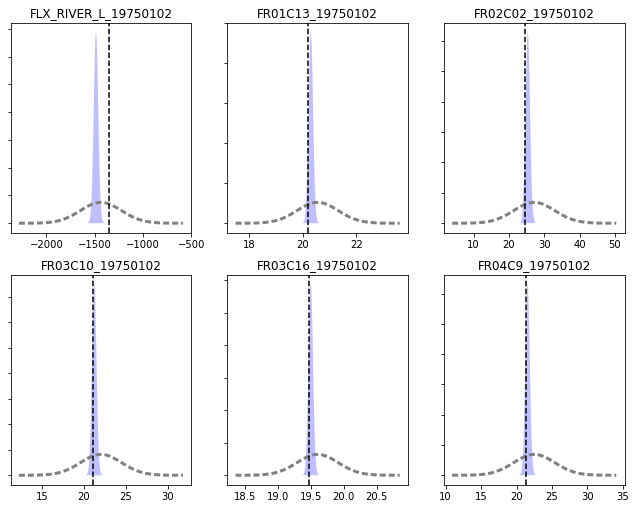

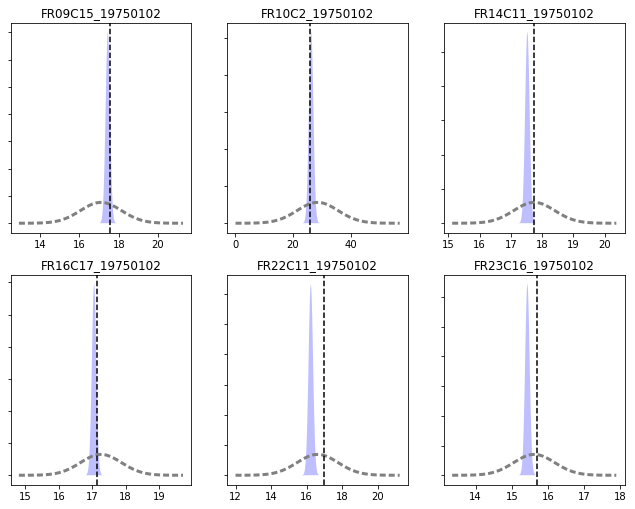

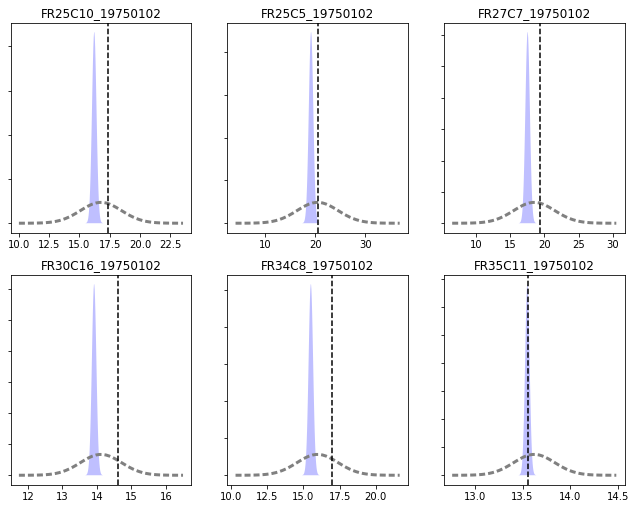

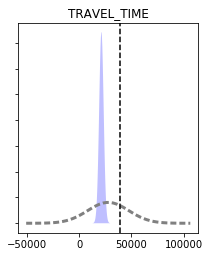

In [33]:
figs, axes = pyemu.helpers.plot_summary_distributions(df_predu,subplots=True)
for ax in axes:
    fname = ax.get_title().lower()
    ylim = ax.get_ylim()
    v = pst.observation_data.loc[fname,"obsval"]
    ax.plot([v,v],ylim,"k--")
    ax.set_ylim(ylim)

uh oh!  Why are some forecasts not bracketed by the posterior distribution? This means uncertainty analysis "failed"! The Prior (uncalibrated model) is more reliable - why?